In [14]:
#Import the libraries
import numpy as np
import pandas as pd

## Download and Unzip the dataset.

In [15]:
url_to_the_zip_file = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/34330/3265183/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647437599&Signature=qVPxXAvAiFlZLpO%2Fp287NXm%2FlUOymBxRMs7NJKMGXlm3afW9PV9LuNalMJS56E%2BjsMSHh46ouLS6gNHYbyPwmdLSQiPpLQPGU6NTKTNprbDUOgYb2rqC4w6AgLOpdRh%2FGdabYAVAdjIh24Teoj5k%2Bs%2Fybm00sxAGf358%2BcxjEonvvUJDEhK7GTtv9NAFxAfsO%2F69xOWSkLEhjjnCwQ3QzfXWxbuYVnqlwy0dwQ6S%2F8iQappRaQg2%2BF9j76t1ay0B3Kg3ANj0P5EuVMDL2KVld3cQLiM7DPi9vQQV531T8snYsbiHjoE%2BhkH6w%2BWeULvu5UpDSaiVRepgtoscjgM8ig%3D%3D&response-content-disposition=attachment%3B+filename%3D2110446-data-science-and-data-engineering-2022.zip"
new_file_name = "2110446-data-science-and-data-engineering-2022.zip"

In [18]:
!rm -f "$new_file_name"
!wget -c "$url_to_the_zip_file" -O "$new_file_name"
!unzip "$new_file_name"

--2022-03-13 14:32:28--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/34330/3265183/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647437599&Signature=qVPxXAvAiFlZLpO%2Fp287NXm%2FlUOymBxRMs7NJKMGXlm3afW9PV9LuNalMJS56E%2BjsMSHh46ouLS6gNHYbyPwmdLSQiPpLQPGU6NTKTNprbDUOgYb2rqC4w6AgLOpdRh%2FGdabYAVAdjIh24Teoj5k%2Bs%2Fybm00sxAGf358%2BcxjEonvvUJDEhK7GTtv9NAFxAfsO%2F69xOWSkLEhjjnCwQ3QzfXWxbuYVnqlwy0dwQ6S%2F8iQappRaQg2%2BF9j76t1ay0B3Kg3ANj0P5EuVMDL2KVld3cQLiM7DPi9vQQV531T8snYsbiHjoE%2BhkH6w%2BWeULvu5UpDSaiVRepgtoscjgM8ig%3D%3D&response-content-disposition=attachment%3B+filename%3D2110446-data-science-and-data-engineering-2022.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6603223 (6.3M) [application/zip]
Saving to: 

## read_csv()

In [206]:
def toDF(pm25_filename, temp_filename, wind_filename):
  pm25_df = pd.read_csv('datasci_dataset_2022/'+pm25_filename, names=['Time', 'PM25'], skiprows=1)
  pm25_df['Time'] = pd.to_datetime(pm25_df['Time'])
  # pm25_df['Time'] = pm25_df['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
  # pm25_df['Time'] = pm25_df['Time'].dt.tz_localize(None)
  pm25_df.set_index('Time', inplace=True)
  pm25_df.columns = ['PM25']
  pm25_df = pm25_df[~pm25_df.index.duplicated(keep='first')]
  pm25_df.index = pd.DatetimeIndex(pm25_df.index)

  temp_df = pd.read_csv('datasci_dataset_2022/'+temp_filename, names=['Time', 'Temp'], skiprows=1)
  temp_df['Time'] = pd.to_datetime(temp_df['Time'])
  temp_df.set_index(temp_df['Time'], inplace=True)
  temp_df.drop(columns={'Time'}, inplace=True)
  temp_df.columns = ['Temp']
  # pad() is similar to fillna() with forward filling
  temp_df = temp_df.resample('h').pad()
  # temp_df.index = pd.DatetimeIndex(temp_df.index)

  wind_df = pd.read_csv('datasci_dataset_2022/'+wind_filename, names=['Time', 'WindSpeed', 'WindDir'], skiprows=1)
  wind_df['Time'] = pd.to_datetime(wind_df['Time'])
  wind_df.set_index(wind_df['Time'], inplace=True)
  wind_df.drop(columns={'Time'}, inplace=True)
  wind_df.columns = ['WindSpeed', 'WindDir']
  # backward filling
  wind_df = wind_df.resample('h').bfill()
  # wind_df.index = pd.DatetimeIndex(wind_df.index)

  pm25_df['copy_index'] = pm25_df.index
  df = pd.merge(pm25_df, temp_df, left_index=True, right_index=True)
  df = pd.merge(df, wind_df, left_index=True, right_index=True)

  df = df[['Temp','WindSpeed','WindDir','PM25']]
  
  # padding first and last indices
  # df = df.ffill()
  # df = df.bfill()

  return df

In [207]:
# def toDFtest(pm25_filename, temp_filename, wind_filename):
#   pm25_df = pd.read_csv('datasci_dataset_2022/'+pm25_filename, names=['Time', 'PM25'], skiprows=1)
#   pm25_df.columns = ['Time', 'PM25']
#   pm25_df['Time'] = pd.to_datetime(pm25_df['Time'], infer_datetime_format=True)
#   pm25_df.set_index('Time', inplace=True)
#   pm25_df = pm25_df[~pm25_df.index.duplicated(keep='first')]
#   pm25_df.index = pd.DatetimeIndex(pm25_df.index)

#   temp_df = pd.read_csv('/kaggle/input/2110446-data-science-and-data-engineering-2021/DS_kaggle_edited_v3/'+temp_filename)
#   temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
#   temp_df.set_index(temp_df['datetime'], inplace=True)
#   temp_df.drop(columns={'datetime','lat','long'}, inplace=True)
#   temp_df.columns = ['Temp']
#   temp_df = temp_df.resample('h').bfill()

#   wind_df = pd.read_csv('/kaggle/input/2110446-data-science-and-data-engineering-2021/DS_kaggle_edited_v3/'+wind_filename)
#   wind_df['datetime'] = pd.to_datetime(wind_df['datetime'])
#   wind_df.set_index(wind_df['datetime'],inplace=True)
#   wind_df.drop(columns={'datetime','lat','long'},inplace=True)
#   wind_df.columns = ['WindDir', 'WindSpeed']
#   wind_df = wind_df.resample('h').bfill()

#   df = pm25_df.merge(temp_df,left_index=True,right_index=True)
#   df = df.merge(wind_df,left_index=True,right_index=True)

#   df = df[['Temp','WindSpeed','WindDir','PM25']]

#   return df

In [208]:
bkk_train = toDF('BKK/train/bkk_train.csv', 'BKK/train/bkk_temp_surface.csv', 'BKK/train/bkk_weather_wind.csv')
# bkk_test = ?

cnx_train = toDF('Chiangmai/train/chiangmai_train.csv', 'Chiangmai/train/chiangmai_temp_surface.csv', 'Chiangmai/train/chiangmai_weather_wind.csv')
# cnx_test = ?

kkc_train = toDF('Khonkaen/train/khonkhan_train.csv', 'Khonkaen/train/khonkaen_temp_surface.csv', 'Khonkaen/train/khonkaen_weather_wind.csv')
# kkc_test = ?

rayong_train = toDF('Rayong/train/rayong_train.csv', 'Rayong/train/rayong_temp_surface.csv', 'Rayong/train/rayong_weather_wind.csv')
# rayong_test = ?

saraburi_train = toDF('Saraburi/train/saraburi_train.csv', 'Saraburi/train/saraburi_temp_surface.csv', 'Saraburi/train/saraburi_weather_wind.csv')
# saraburi_test = ?

surat_train = toDF('Surat/train/surat_train.csv', 'Surat/train/surat_temp_surface.csv', 'Surat/train/surat_weather_wind.csv')
# surat_test = ?

In [282]:
train_set={}

In [283]:
train_set['BKK'] = bkk_train
train_set['CNX'] = cnx_train
train_set['KKC'] = kkc_train
train_set['RAY'] = rayong_train
train_set['SARA'] = saraburi_train
train_set['SURAT'] = surat_train

## display()

In [220]:
display(bkk_train)

,Temp,WindSpeed,WindDir,PM25
Time,,,,
2017-07-01 01:00:00,27.9,16,260,10.0
2017-07-01 02:00:00,27.9,16,255,17.0
2017-07-01 03:00:00,27.9,16,255,20.0
2017-07-01 04:00:00,27.4,16,255,15.0
2017-07-01 05:00:00,27.4,17,235,16.0
...,...,...,...,...
2020-06-30 18:00:00,32.1,36,265,11.0
2020-06-30 19:00:00,30.3,36,265,15.0
2020-06-30 20:00:00,30.3,35,270,14.0


In [221]:
display(cnx_train)

,Temp,WindSpeed,WindDir,PM25
Time,,,,
2017-07-01 01:00:00,23.2,32,235,5.0
2017-07-01 02:00:00,23.2,30,250,16.0
2017-07-01 03:00:00,23.2,30,250,11.0
2017-07-01 04:00:00,22.3,30,250,12.0
2017-07-01 05:00:00,22.3,30,250,15.0
...,...,...,...,...
2020-06-30 18:00:00,32.2,16,235,10.0
2020-06-30 19:00:00,27.5,16,235,16.0
2020-06-30 20:00:00,27.5,17,225,19.0


In [222]:
display(kkc_train)

,Temp,WindSpeed,WindDir,PM25
Time,,,,
2017-07-01 01:00:00,26.5,28,235,7.0
2017-07-01 02:00:00,26.5,29,245,4.0
2017-07-01 03:00:00,26.5,29,245,9.0
2017-07-01 04:00:00,25.8,29,245,8.0
2017-07-01 05:00:00,25.8,28,245,6.0
...,...,...,...,...
2020-06-30 18:00:00,29.6,20,235,17.0
2020-06-30 19:00:00,29.6,20,235,13.0
2020-06-30 20:00:00,29.6,21,230,18.0


In [223]:
display(rayong_train)

,Temp,WindSpeed,WindDir,PM25
Time,,,,
2017-07-01 01:00:00,27.9,21,250,6.0
2017-07-01 02:00:00,27.9,21,250,6.0
2017-07-01 03:00:00,27.9,21,250,5.0
2017-07-01 04:00:00,27.7,21,250,10.0
2017-07-01 05:00:00,27.7,22,230,9.0
...,...,...,...,...
2020-06-30 18:00:00,28.0,36,280,8.0
2020-06-30 19:00:00,27.9,36,280,11.0
2020-06-30 20:00:00,27.9,47,270,10.0


In [224]:
display(saraburi_train)

,Temp,WindSpeed,WindDir,PM25
Time,,,,
2017-07-01 01:00:00,26.6,38,250,16.0
2017-07-01 02:00:00,26.6,38,250,13.0
2017-07-01 03:00:00,26.6,38,250,18.0
2017-07-01 04:00:00,26.0,38,250,29.0
2017-07-01 05:00:00,26.0,38,250,32.0
...,...,...,...,...
2020-06-30 18:00:00,31.8,31,245,11.0
2020-06-30 19:00:00,27.4,31,245,17.0
2020-06-30 20:00:00,27.4,41,250,19.0


In [225]:
display(surat_train)

,Temp,WindSpeed,WindDir,PM25
Time,,,,
2018-10-01 00:00:00,26.6,3,90,22.0
2018-10-01 01:00:00,25.8,3,90,17.0
2018-10-01 02:00:00,25.8,1,105,13.0
2018-10-01 03:00:00,25.8,1,105,12.0
2018-10-01 04:00:00,25.2,1,105,11.0
...,...,...,...,...
2020-06-30 18:00:00,30.8,19,250,36.0
2020-06-30 19:00:00,26.7,19,250,29.0
2020-06-30 20:00:00,26.7,23,260,16.0


## Number of null values

### Before Dropping

In [219]:
null_counts_bkk_train = bkk_train.isnull().sum()
print("[bkk_train] Number of null values in each column:\n{}".format(null_counts_bkk_train))
print('\n')

null_counts_cnx_train = cnx_train.isnull().sum()
print("[cnx_train] Number of null values in each column:\n{}".format(null_counts_cnx_train))
print('\n')

null_counts_kkc_train = kkc_train.isnull().sum()
print("[kkc_train] Number of null values in each column:\n{}".format(null_counts_kkc_train))
print('\n')

null_counts_rayong_train = rayong_train.isnull().sum()
print("[rayong_train] Number of null values in each column:\n{}".format(null_counts_rayong_train))
print('\n')

null_counts_saraburi_train = saraburi_train.isnull().sum()
print("[saraburi_train] Number of null values in each column:\n{}".format(null_counts_saraburi_train))
print('\n')

null_counts_surat_train = surat_train.isnull().sum()
print("[surat_train] Number of null values in each column:\n{}".format(null_counts_surat_train))

[bkk_train] Number of null values in each column:
Temp           3
WindSpeed      0
WindDir        0
PM25         176
dtype: int64


[cnx_train] Number of null values in each column:
Temp           6
WindSpeed      0
WindDir        0
PM25         470
dtype: int64


[kkc_train] Number of null values in each column:
Temp            0
WindSpeed       0
WindDir         0
PM25         2689
dtype: int64


[rayong_train] Number of null values in each column:
Temp            0
WindSpeed       0
WindDir         0
PM25         2126
dtype: int64


[saraburi_train] Number of null values in each column:
Temp            0
WindSpeed       0
WindDir         0
PM25         1588
dtype: int64


[surat_train] Number of null values in each column:
Temp         126
WindSpeed      0
WindDir        0
PM25         369
dtype: int64


### Drop null-valued rows (Temp & PM25)

In [228]:
bkk_train.dropna(subset=['Temp','PM25'],inplace=True)

cnx_train.dropna(subset=['Temp','PM25'],inplace=True)

kkc_train.dropna(subset=['Temp','PM25'],inplace=True)

rayong_train.dropna(subset=['Temp','PM25'],inplace=True)

saraburi_train.dropna(subset=['Temp','PM25'],inplace=True)

surat_train.dropna(subset=['Temp','PM25'],inplace=True)

## Handle outliers

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, skew

%matplotlib inline

In [285]:
class Handle_Outliers:
  def __init__(self, dataset):
    self.dataset=dataset
   
  def plotIQR(self, province, col, title=""):
    dataset = self.dataset

    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.title(title)
    plt.xlim(dataset[province][col].min(), dataset[province][col].max()*1.1)

    ax = dataset[province][col].plot(kind='kde')

    plt.subplot(212)
    plt.xlim(dataset[province][col].min(), dataset[province][col].max()*1.1)
    sns.boxplot(x=dataset[province][col])

    plt.show()
  
  def showKS(self, province, col):
    dataset = self.dataset
    
    kurtosis_value = kurtosis(dataset[province][col])
    print("kurtosis_value = ", kurtosis_value)
    skew_value = skew(dataset[province][col])
    print("skew_value = ", skew_value)

### Using IQR to detect outliers

In [287]:
handle_outliers = Handle_Outliers(train_set)

#### Before Log

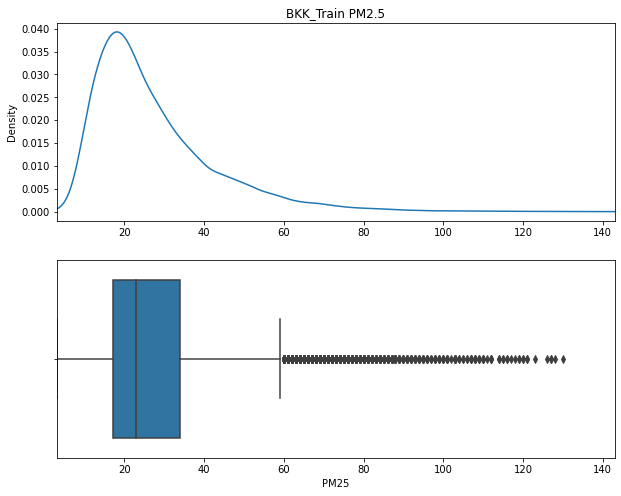

kurtosis_value =  3.7542328442592394
skew_value =  1.6427231226444095


In [288]:
handle_outliers.plotIQR('BKK', 'PM25', "Bangkok_Train PM2.5")
handle_outliers.showKS('BKK', 'PM25')

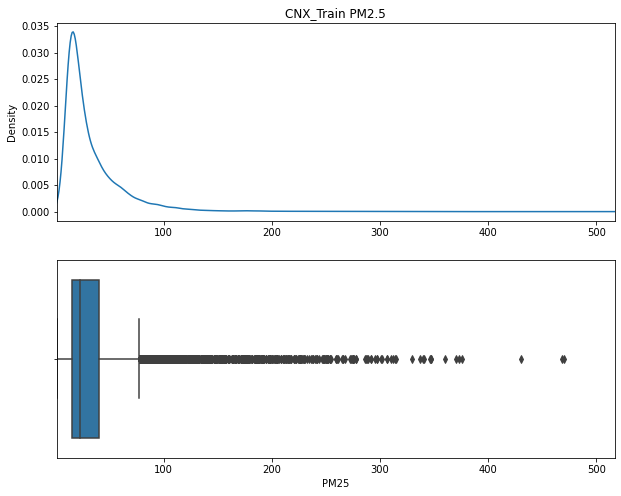

kurtosis_value =  22.160191851504727
skew_value =  3.6004308937451492


In [289]:
handle_outliers.plotIQR('CNX', 'PM25', "Chiangmai_Train PM2.5")
handle_outliers.showKS('CNX', 'PM25')

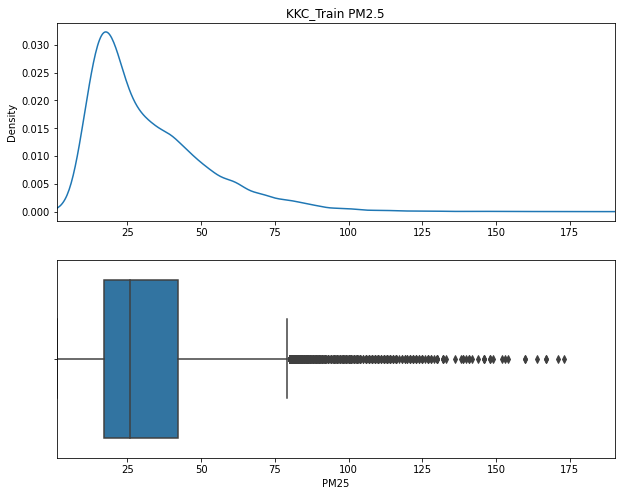

kurtosis_value =  2.852633308292953
skew_value =  1.4363591505579454


In [260]:
handle_outliers.plotIQR('KKC', 'PM25', "Khonkaen_Train PM2.5")
handle_outliers.showKS('KKC', 'PM25')

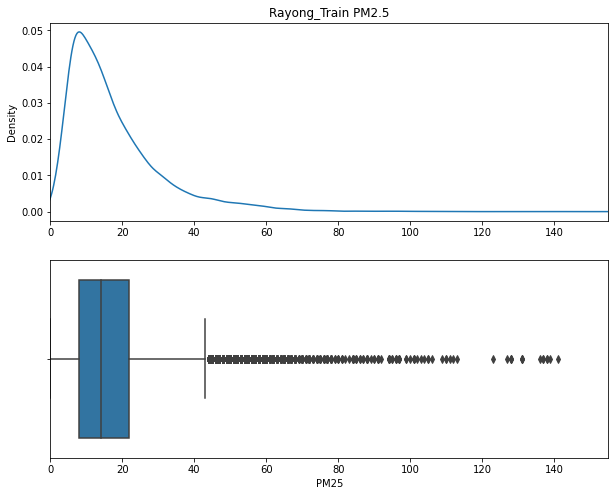

kurtosis_value =  7.6970807915660515
skew_value =  2.13269492588504


In [290]:
handle_outliers.plotIQR('RAY', 'PM25', "Rayong_Train PM2.5")
handle_outliers.showKS('RAY', 'PM25')

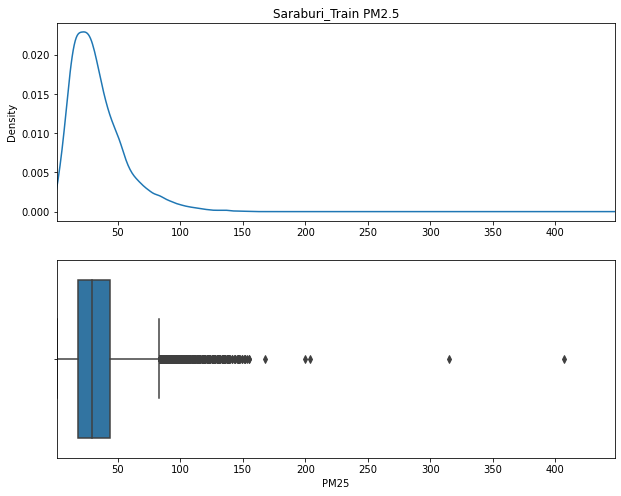

kurtosis_value =  6.864162324600022
skew_value =  1.650534135184398


In [291]:
handle_outliers.plotIQR("SARA", 'PM25', "Saraburi_Train PM2.5")
handle_outliers.showKS("SARA", 'PM25')

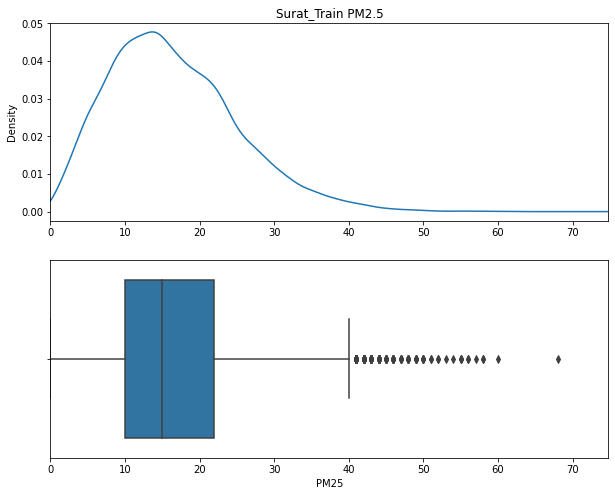

kurtosis_value =  0.6334880093938624
skew_value =  0.7291329868115642


In [293]:
handle_outliers.plotIQR('SURAT', 'PM25', "Surat_Train PM2.5")
handle_outliers.showKS('SURAT', 'PM25')

#### After Log

In [294]:
train_set['BKK']['Log_PM25'] = np.log(1+train_set['BKK']['PM25'])
train_set['CNX']['Log_PM25'] = np.log(1+train_set['CNX']['PM25'])
train_set['KKC']['Log_PM25'] = np.log(1+train_set['KKC']['PM25'])
train_set['RAY']['Log_PM25'] = np.log(1+train_set['RAY']['PM25'])
train_set['SARA']['Log_PM25'] = np.log(1+train_set['SARA']['PM25'])
train_set['SURAT']['Log_PM25'] = np.log(1+train_set['SURAT']['PM25'])

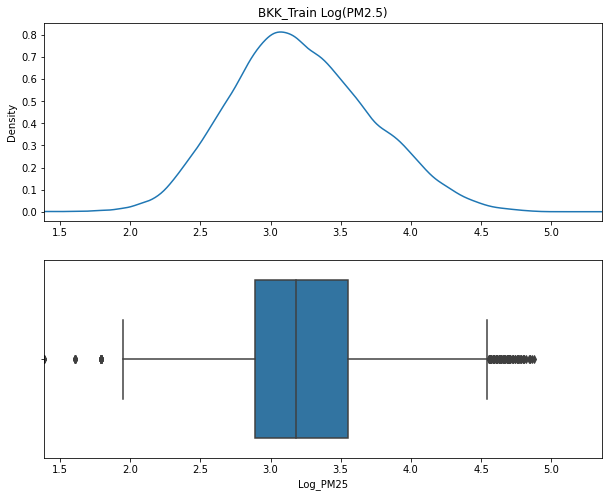

kurtosis_value =  -0.19354695008339684
skew_value =  0.2150268983994971


In [295]:
handle_outliers.plotIQR('BKK', 'Log_PM25', "Bangkok_Train Log(PM2.5)")
handle_outliers.showKS('BKK', 'Log_PM25')

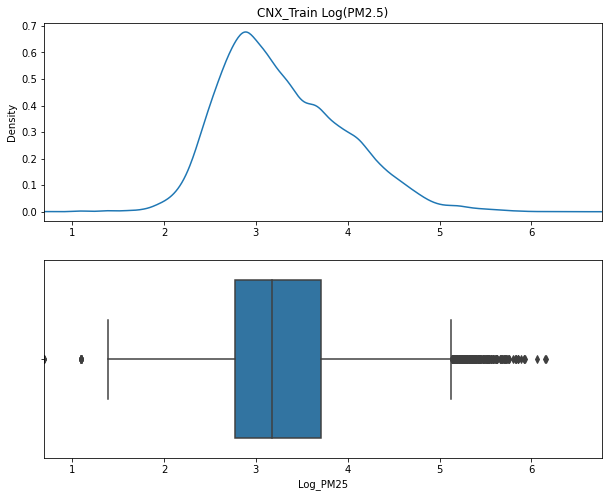

kurtosis_value =  0.16234853991746867
skew_value =  0.5609039691419486


In [296]:
handle_outliers.plotIQR('CNX', 'Log_PM25', "Chiangmai_Train Log(PM2.5)")
handle_outliers.showKS('CNX', 'Log_PM25')

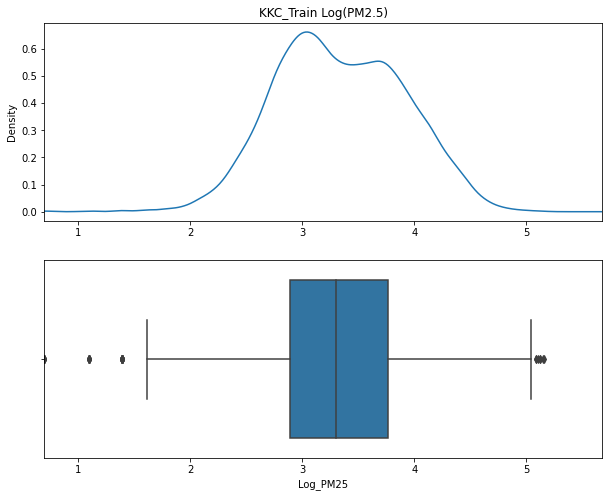

kurtosis_value =  -0.21392060653719458
skew_value =  -0.013772394097134611


In [297]:
handle_outliers.plotIQR('KKC', 'Log_PM25', "Khonkaen_Train Log(PM2.5)")
handle_outliers.showKS('KKC', 'Log_PM25')

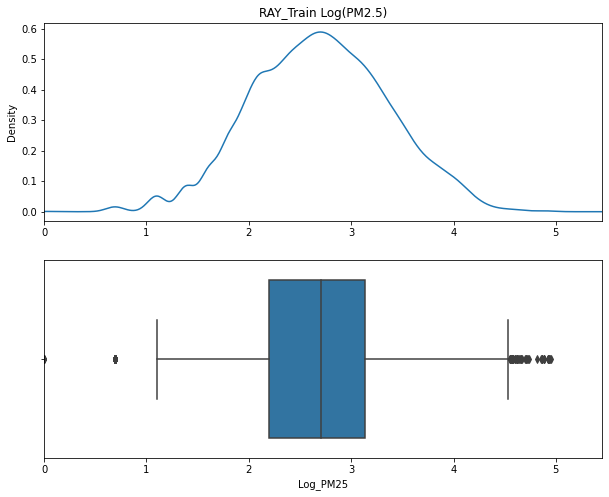

kurtosis_value =  -0.0970150611450924
skew_value =  -0.0034067186098447467


In [298]:
handle_outliers.plotIQR('RAY', 'Log_PM25', "Rayong_Train Log(PM2.5)")
handle_outliers.showKS('RAY', 'Log_PM25')

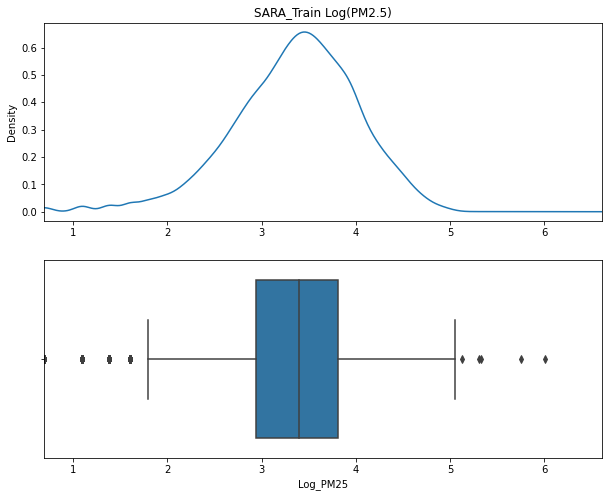

kurtosis_value =  0.90036786488337
skew_value =  -0.5859147529476278


In [299]:
handle_outliers.plotIQR('SARA', 'Log_PM25', "Saraburi_Train Log(PM2.5)")
handle_outliers.showKS('SARA', 'Log_PM25')

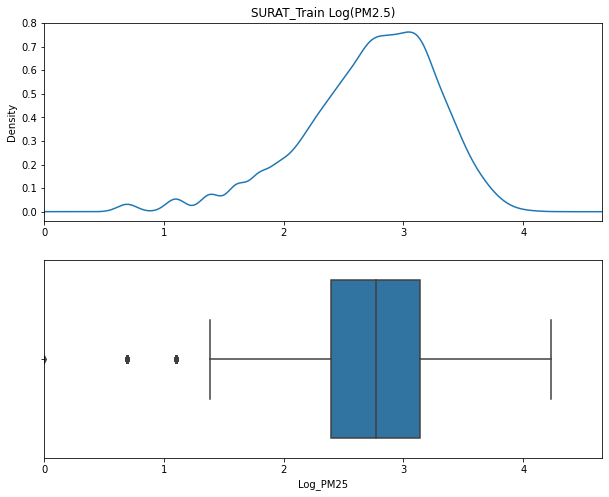

kurtosis_value =  0.7869783044769383
skew_value =  -0.7758753751207673


In [300]:
handle_outliers.plotIQR('SURAT', 'Log_PM25', "Surat_Train Log(PM2.5)")
handle_outliers.showKS('SURAT', 'Log_PM25')

#### Cut with IQR

ยังทำไม่เสร็จ

In [301]:
q75, q25 = np.percentile(train_set['BKK'].Log_PM25.dropna(), [75 ,25])
iqr = q75 - q25

min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

print(iqr)

0.664976303593249


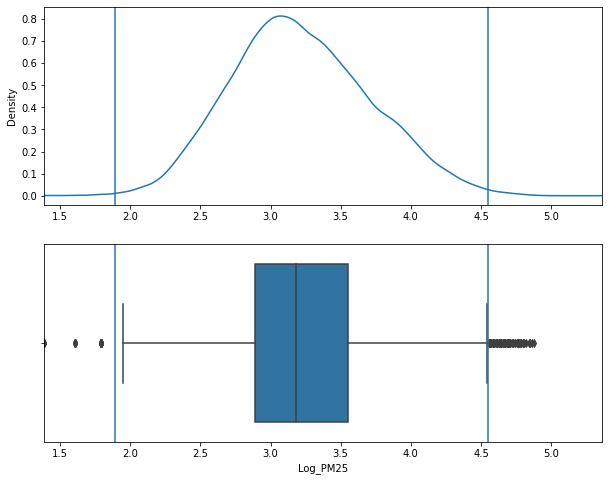

In [302]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(train_set['BKK'].Log_PM25.min(), train_set['BKK'].Log_PM25.max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)

ax = train_set['BKK'].Log_PM25.plot(kind='kde')

plt.subplot(212)
plt.xlim(train_set['BKK'].Log_PM25.min(), train_set['BKK'].Log_PM25.max()*1.1)
sns.boxplot(x=train_set['BKK'].Log_PM25)
plt.axvline(x=min)
plt.axvline(x=max)

In [306]:
df_out = train_set['BKK'].copy()

In [309]:
df_out.loc[df_out['Log_PM25']<min, 'Log_PM25'] = min
df_out.loc[df_out['Log_PM25']>max, 'Log_PM25'] = max

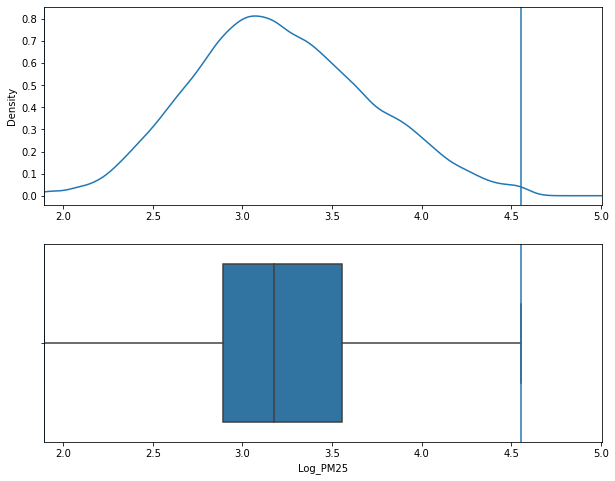

In [311]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df_out.Log_PM25.min(), df_out.Log_PM25.max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)

ax = df_out.Log_PM25.plot(kind='kde')

plt.subplot(212)
plt.xlim(df_out.Log_PM25.min(), df_out.Log_PM25.max()*1.1)
sns.boxplot(x=df_out.Log_PM25)
plt.axvline(x=min)
plt.axvline(x=max)

In [312]:
train_set['BKK'].describe(include='all')

,Temp,WindSpeed,WindDir,PM25,Log_PM25
count,26123.000000,26123.000000,26123.000000,26123.000000,26123.000000
mean,29.803254,20.499368,167.735329,27.298052,3.216784
std,2.653206,13.039739,92.336964,15.382631,0.494660
min,17.200000,0.000000,0.000000,3.000000,1.386294
25%,28.000000,11.000000,80.000000,17.000000,2.890372
50%,29.600000,17.000000,155.000000,23.000000,3.178054
75%,31.600000,27.000000,260.000000,34.000000,3.555348
max,38.100000,85.000000,360.000000,130.000000,4.875197


In [315]:
df_out['new_PM25'] = (np.exp(df_out['Log_PM25'])-1)
df_out.describe(include='all')

,Temp,WindSpeed,WindDir,PM25,Log_PM25,back_log,new_PM25
count,26123.000000,26123.000000,26123.000000,26123.000000,26123.000000,26123.000000,26123.000000
mean,29.803254,20.499368,167.735329,27.298052,3.216612,27.255783,27.255783
std,2.653206,13.039739,92.336964,15.382631,0.492703,15.162809,15.162809
min,17.200000,0.000000,0.000000,3.000000,1.892907,5.638641,5.638641
25%,28.000000,11.000000,80.000000,17.000000,2.890372,17.000000,17.000000
50%,29.600000,17.000000,155.000000,23.000000,3.178054,23.000000,23.000000
75%,31.600000,27.000000,260.000000,34.000000,3.555348,34.000000,34.000000
max,38.100000,85.000000,360.000000,130.000000,4.552813,93.898938,93.898938
